Load images

In [ ]:
!pip -q install huggingface_hub datasets pillow requests

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
project_path = '/content/drive/My Drive/Colab Notebooks/anime'
os.makedirs(project_path, exist_ok=True)
os.chdir(project_path)
print(f"Current working directory: {os.getcwd()}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/My Drive/Colab Notebooks/anime


In [ ]:
from huggingface_hub import login, hf_hub_download
from datasets import load_dataset
import subprocess

HF_TOKEN = "" # Replace with your actual token
login(token=HF_TOKEN)

repo_id = "Ray-mewtant/mewtant-interview-project"

tar_path = hf_hub_download(
    repo_id=repo_id,
    filename="zip1.tar",
    repo_type="dataset",
    token=HF_TOKEN,
)
print("Downloaded:", tar_path)

extract_dir = "./content/origin_zip1"
os.makedirs(extract_dir, exist_ok=True)

subprocess.run(["tar", "-xf", tar_path, "-C", extract_dir], check=True)

ds = load_dataset("imagefolder", data_dir=extract_dir, split="train")
print(ds)
print(ds[0]["image"])

zip1.tar:   0%|          | 0.00/3.35G [00:00<?, ?B/s]

Downloaded: /root/.cache/huggingface/hub/datasets--Ray-mewtant--mewtant-interview-project/snapshots/7029bd97d8de1d1b285950ddacc4146061d4daf3/zip1.tar


Resolving data files:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image'],
    num_rows: 10000
})
<PIL.WebPImagePlugin.WebPImageFile image mode=RGB size=700x499 at 0x7C400252C500>


Manually label images for classifier fine-tunning

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.models import efficientnet_b0
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
import shutil
from PIL import Image
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

'''
#Load and modify EfficientNet-B0
print("Loading EfficientNet-B0...")
model = efficientnet_b0(weights='IMAGENET1K_V1')  # Pretrained on ImageNet

# Replace the classifier head for binary classification
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 2)  # 2 classes: anime vs realistic, original classifier outputs 1000 logits
)
model = model.to(device)
model.eval()  # Set to evaluation
print("Model ready!")
'''

Using device: cuda


'\n#Load and modify EfficientNet-B0\nprint("Loading EfficientNet-B0...")\nmodel = efficientnet_b0(weights=\'IMAGENET1K_V1\')  # Pretrained on ImageNet\n\n# Replace the classifier head for binary classification\nmodel.classifier = nn.Sequential(\n    nn.Dropout(p=0.2, inplace=True),\n    nn.Linear(1280, 2)  # 2 classes: anime vs realistic, original classifier outputs 1000 logits\n)\nmodel = model.to(device)\nmodel.eval()  # Set to evaluation\nprint("Model ready!")\n'

In [ ]:
def prepare_training_data(extract_dir, sample_size=300):
    """
    Create a small labeled dataset by manually sorting SOME images

    """

    train_dir = "./training_data"
    anime_dir = os.path.join(train_dir, "anime")
    realistic_dir = os.path.join(train_dir, "realistic")

    os.makedirs(anime_dir, exist_ok=True)
    os.makedirs(realistic_dir, exist_ok=True)

    # Get all image paths from zip1
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
    all_images = []

    for root, dirs, files in os.walk(extract_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                all_images.append(os.path.join(root, file))

    print(f"Found {len(all_images)} total images in zip1")
    print(f"\n=== MANUAL STEP REQUIRED ===")
    print(f"1. Look at first {sample_size} images")
    print(f"2. Copy CLEAR anime examples to: {anime_dir}")
    print(f"3. Copy CLEAR realistic examples to: {realistic_dir}")
    print(f"4. Aim for ~100 images in each folder")
    print(f"5. Use these commands to preview:")

    # Show first 20 images for quick manual sorting
    preview_images = all_images[:20]
    for i, img_path in enumerate(preview_images):
        print(f"   {i+1}. {os.path.basename(img_path)}")

    return train_dir

# Run this once to setup directories
extract_dir = "./content/zip1"  # Your extracted folder
training_root = prepare_training_data(extract_dir)

Found 10000 total images in zip1

=== MANUAL STEP REQUIRED ===
1. Look at first 300 images
2. Copy CLEAR anime examples to: ./training_data/anime
3. Copy CLEAR realistic examples to: ./training_data/realistic
4. Aim for ~100 images in each folder
5. Use these commands to preview:
   1. twitter-1447119855874834433_1.webp
   2. twitter-1448262872975302665_1.webp
   3. twitter-1448937153518469122_1.webp
   4. twitter-1449674416607010818_2.webp
   5. twitter-1450050809673109506_1.webp
   6. twitter-1450050809673109506_2.webp
   7. twitter-1450050809673109506_3.webp
   8. twitter-1450050809673109506_4.webp
   9. twitter-1451482400739893249_1.webp
   10. twitter-1452206641017810945_1.webp
   11. twitter-1452934329676402688_1.webp
   12. twitter-1452934329676402688_2.webp
   13. twitter-1454015542705238020_1.webp
   14. twitter-1454742903545217028_1.webp
   15. twitter-1454742903545217028_2.webp
   16. twitter-1454742903545217028_3.webp
   17. twitter-1454742903545217028_4.webp
   18. twitter

In [ ]:
print(training_root)

./training_data


I manually labeled some images to train the classifier for efficientnet_b0, and they are in the file training_data

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, random_split
import os
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root="./training_data", transform=train_transform)
print(f"Total images: {len(train_dataset)}")
print(f"Classes: {train_dataset.classes}")
print(f"Class to index: {train_dataset.class_to_idx}")

#train/validation (8/2)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# apply validation transform
val_subset.dataset.transform = val_transform


batch_size = 16  # small batch for small dataset
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\nData loaded:")
print(f"  Training samples: {len(train_subset)}")
print(f"  Validation samples: {len(val_subset)}")
print(f"  Batch size: {batch_size}")


Using device: cuda
Total images: 140
Classes: ['anime', 'realistic']
Class to index: {'anime': 0, 'realistic': 1}

Data loaded:
  Training samples: 112
  Validation samples: 28
  Batch size: 16


In [18]:
def create_model():
    """Create and configure EfficientNet-B0 for binary classification"""
    model = models.efficientnet_b0(weights='IMAGENET1K_V1')

    # freeze early layers
    for param in model.parameters():
        param.requires_grad = False

    # unfreeze the classifier and last few layers
    for param in model.classifier.parameters():
        param.requires_grad = True
    for param in model.features[-3:].parameters():  # Last 3 blocks
        param.requires_grad = True

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(1280, 2)  # 2 classes: anime vs realistic
    )

    return model.to(device)

model = create_model()


STARTING TRAINING (15 epochs)

Epoch 1/15


  Train: Loss=0.6173, Acc=70.5%
  Val:   Loss=0.4510, Acc=89.3%
Saved best model (Acc: 89.3%)

Epoch 2/15


  Train: Loss=0.3949, Acc=86.6%
  Val:   Loss=0.3762, Acc=89.3%

Epoch 3/15


  Train: Loss=0.2616, Acc=93.8%
  Val:   Loss=0.3506, Acc=89.3%

Epoch 4/15


  Train: Loss=0.1795, Acc=97.3%
  Val:   Loss=0.3462, Acc=92.9%
Saved best model (Acc: 92.9%)

Epoch 5/15


  Train: Loss=0.1069, Acc=98.2%
  Val:   Loss=0.3480, Acc=92.9%

Epoch 6/15


  Train: Loss=0.0902, Acc=100.0%
  Val:   Loss=0.3580, Acc=92.9%

Epoch 7/15


  Train: Loss=0.0489, Acc=100.0%
  Val:   Loss=0.3690, Acc=92.9%

Epoch 8/15


  Train: Loss=0.0578, Acc=100.0%
  Val:   Loss=0.3983, Acc=92.9%

Epoch 9/15


  Train: Loss=0.0393, Acc=100.0%
  Val:   Loss=0.3949, Acc=92.9%

Epoch 10/15


  Train: Loss=0.0288, Acc=100.0%
  Val:   Loss=0.3914, Acc=92.9%

Epoch 11/15


  Train: Loss=0.0152, Acc=100.0%
  Val:   Loss=0.4006, Acc=92.9%

Epoch 12/15


  Train: Loss=0.0200, Acc=100.0%
  Val:   Loss=0.3966, Acc=92.9%

Epoch 13/15


  Train: Loss=0.0202, Acc=100.0%
  Val:   Loss=0.4014, Acc=92.9%

Epoch 14/15


  Train: Loss=0.0230, Acc=100.0%
  Val:   Loss=0.4086, Acc=92.9%

Epoch 15/15


  Train: Loss=0.0190, Acc=100.0%
  Val:   Loss=0.4115, Acc=92.9%

Best validation accuracy: 92.9%


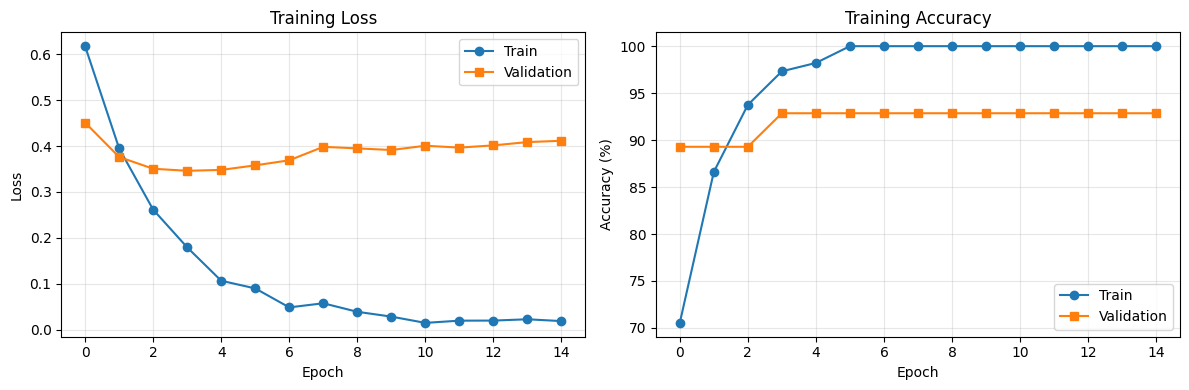


Loaded best model from epoch 4
Validation accuracy: 92.9%


In [19]:
import matplotlib.pyplot as plt
def train_epoch(model, loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Training", leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'loss': f'{total_loss/(pbar.n+1):.4f}',
            'acc': f'{100.*correct/total:.1f}%'
        })

    return total_loss/len(loader), 100.*correct/total

def validate(model, loader, criterion):
    """Validate model"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return total_loss/len(loader), 100.*correct/total

# training configuration
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW([
    {'params': model.features.parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
])

# lr_scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

epochs = 15
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'lr': []
}

print(f"\n{'='*60}")
print(f"STARTING TRAINING (15 epochs)")
print(f"{'='*60}")

best_val_acc = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    # update scheduler
    scheduler.step(val_acc)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])

    print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.1f}%")
    print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.1f}%")

    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_to_idx': train_dataset.class_to_idx
        }, "best_model.pth")
        print(f"Saved best model (Acc: {val_acc:.1f}%)")

print(f"\n{'='*60}")
print(f"Best validation accuracy: {best_val_acc:.1f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history['train_loss'], label='Train', marker='o')
ax1.plot(history['val_loss'], label='Validation', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_acc'], label='Train', marker='o')
ax2.plot(history['val_acc'], label='Validation', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best model from epoch {checkpoint['epoch']+1}")
print(f"Validation accuracy: {checkpoint['val_acc']:.1f}%")

Some testing to show the pipeline is working to some extent.

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import os
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.efficientnet_b0()
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 2)
)

checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"Model from epoch {checkpoint['epoch'] + 1}")
print(f"Class mapping: {checkpoint['class_to_idx']}")

#get class names from the mapping
class_names = list(checkpoint['class_to_idx'].keys())
print(f"Classes: {class_names}")

#transform test image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dir = "./testing_data"

# count test images
anime_test = len([f for f in os.listdir(os.path.join(test_dir, "test_anime"))
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))])
realistic_test = len([f for f in os.listdir(os.path.join(test_dir, "test_realistic"))
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))])

correct = 0
total = 0

print("\nTesting each image...")

# test anime
anime_folder = os.path.join(test_dir, "test_anime")
for img_name in os.listdir(anime_folder):
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
        img_path = os.path.join(anime_folder, img_name)

        try:
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(img_tensor)
                probs = torch.softmax(outputs, dim=1)
                anime_prob = probs[0][0].item()

                # prediction (anime if > 0.5)
                predicted = "anime" if anime_prob > 0.5 else "realistic"

                if predicted == "anime":
                    correct += 1

                total += 1

        except Exception as e:
            print(f"  Error with {img_name}: {e}")

# test realistic
realistic_folder = os.path.join(test_dir, "test_realistic")
for img_name in os.listdir(realistic_folder):
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
        img_path = os.path.join(realistic_folder, img_name)

        try:
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(img_tensor)
                probs = torch.softmax(outputs, dim=1)
                anime_prob = probs[0][0].item()

                predicted = "anime" if anime_prob > 0.5 else "realistic"

                if predicted == "realistic":
                    correct += 1


                total += 1

        except Exception as e:
            print(f"  Error with {img_name}: {e}")


print("\n" + "="*50)
print("FINAL TEST RESULTS")

accuracy = 100 * correct / total if total > 0 else 0

print(f"Test Set Size: {total} images")
print(f"Correct Predictions: {correct}/{total}")
print(f"Accuracy: {accuracy:.1f}%")
print(f"Training Validation Accuracy: {checkpoint['val_acc']:.1f}%")

Model from epoch 7
Class mapping: {'anime': 0, 'realistic': 1}
Classes: ['anime', 'realistic']

Testing each image...

FINAL TEST RESULTS
Test Set Size: 43 images
Correct Predictions: 38/43
Accuracy: 88.4%
Training Validation Accuracy: 92.9%


The test accuracy is 88.4%, which definitely can be pushed higher when trained with a much more solid 200+ dataset (current training data set is only 70 per class.)

classify all zip file.

In [ ]:
import os, glob
import torch
import torch.nn as nn
from torchvision import models, transforms
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#Load model
ckpt = torch.load("best_model.pth", map_location=device)
class_to_idx = ckpt["class_to_idx"]
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(f"Class mapping: {idx_to_class}")

Using device: cuda
Class mapping: {0: 'anime', 1: 'realistic'}


In [ ]:
#rebuild model
model = models.efficientnet_b0(weights=None)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 2)
)
model.load_state_dict(ckpt["model_state_dict"])
model = model.to(device).eval()
print("Model loaded.")

#transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#get all image paths
ROOT = "./content/origin_zip1"  # Your zip1 folder
exts = (".jpg", ".jpeg", ".png", ".webp", ".bmp")

print(f"Scanning {ROOT} for images...")
paths = []
for root, _, files in os.walk(ROOT):
    for f in files:
        if f.lower().endswith(exts):
            paths.append(os.path.join(root, f))

print(f"Total images found: {len(paths)}")

Model loaded.
Scanning ./content/origin_zip1 for images...
Total images found: 10000


In [ ]:
batch_size = 32
rows = []

for i in tqdm(range(0, len(paths), batch_size), desc="Processing"):
    batch_paths = paths[i:i+batch_size]
    batch_images = []
    batch_rel_ids = []

    #load batch size = 32
    for img_path in batch_paths:
        try:
            img = Image.open(img_path).convert('RGB')
            batch_images.append(transform(img))
            batch_rel_ids.append(os.path.relpath(img_path, ROOT))
        except:
            continue

    if not batch_images:
        continue

    batch_tensor = torch.stack(batch_images).to(device)
    with torch.no_grad():
        outputs = model(batch_tensor)
        probs = torch.softmax(outputs, dim=1)
        predictions = probs.argmax(dim=1).cpu().numpy()

    for rel_id, yi in zip(batch_rel_ids, predictions):
        rows.append({
            "image_id": rel_id,
            "label": idx_to_class[int(yi)]
        })
    print(i)

#handle remaining images
processed_ids = {row["image_id"] for row in rows}
for img_path in paths:
    rel_id = os.path.relpath(img_path, ROOT)
    if rel_id not in processed_ids:
        try:
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                outputs = model(img_tensor)
                yi = torch.softmax(outputs, dim=1).argmax().item()
            rows.append({
                "image_id": rel_id,
                "label": idx_to_class[int(yi)]
            })
        except:
            rows.append({
                "image_id": rel_id,
                "label": "error"
            })

pred_df = pd.DataFrame(rows)
pred_df.to_parquet("./zip1_predictions.parquet", index=False)

Processing:   0%|          | 1/313 [00:01<09:18,  1.79s/it]

0


Processing:   1%|          | 2/313 [00:03<08:55,  1.72s/it]

32


Processing:   1%|          | 3/313 [00:05<09:00,  1.74s/it]

64


Processing:   1%|▏         | 4/313 [01:08<2:13:57, 26.01s/it]

96


Processing:   2%|▏         | 5/313 [01:09<1:26:26, 16.84s/it]

128


Processing:   2%|▏         | 6/313 [01:09<57:53, 11.32s/it]  

160


Processing:   2%|▏         | 7/313 [01:10<39:53,  7.82s/it]

192


Processing:   3%|▎         | 8/313 [01:11<29:10,  5.74s/it]

224


Processing:   3%|▎         | 9/313 [01:13<22:59,  4.54s/it]

256


Processing:   3%|▎         | 10/313 [01:15<19:32,  3.87s/it]

288


Processing:   4%|▎         | 11/313 [01:18<17:52,  3.55s/it]

320


Processing:   4%|▍         | 12/313 [01:22<18:35,  3.71s/it]

352


Processing:   4%|▍         | 13/313 [01:26<19:12,  3.84s/it]

384


Processing:   4%|▍         | 14/313 [01:30<18:36,  3.73s/it]

416


Processing:   5%|▍         | 15/313 [01:34<18:49,  3.79s/it]

448


Processing:   5%|▌         | 16/313 [01:38<19:54,  4.02s/it]

480


Processing:   5%|▌         | 17/313 [01:43<20:40,  4.19s/it]

512


Processing:   6%|▌         | 18/313 [01:46<19:03,  3.88s/it]

544


Processing:   6%|▌         | 19/313 [01:51<20:05,  4.10s/it]

576


Processing:   6%|▋         | 20/313 [01:54<18:30,  3.79s/it]

608


Processing:   7%|▋         | 21/313 [01:57<16:58,  3.49s/it]

640


Processing:   7%|▋         | 22/313 [01:58<14:03,  2.90s/it]

672


Processing:   7%|▋         | 23/313 [02:00<12:04,  2.50s/it]

704


Processing:   8%|▊         | 24/313 [02:01<10:23,  2.16s/it]

736


Processing:   8%|▊         | 25/313 [02:03<10:25,  2.17s/it]

768


Processing:   8%|▊         | 26/313 [02:05<10:26,  2.18s/it]

800


Processing:   9%|▊         | 27/313 [02:07<10:13,  2.15s/it]

832


Processing:   9%|▉         | 28/313 [02:10<10:30,  2.21s/it]

864


Processing:   9%|▉         | 29/313 [02:12<10:24,  2.20s/it]

896


Processing:  10%|▉         | 30/313 [02:14<10:39,  2.26s/it]

928


Processing:  10%|▉         | 31/313 [02:16<10:26,  2.22s/it]

960


Processing:  10%|█         | 32/313 [02:19<11:18,  2.42s/it]

992


Processing:  11%|█         | 33/313 [02:23<12:19,  2.64s/it]

1024


Processing:  11%|█         | 34/313 [02:28<15:42,  3.38s/it]

1056


Processing:  11%|█         | 35/313 [02:30<14:34,  3.15s/it]

1088


Processing:  12%|█▏        | 36/313 [02:33<14:11,  3.07s/it]

1120


Processing:  12%|█▏        | 37/313 [02:37<15:05,  3.28s/it]

1152


Processing:  12%|█▏        | 38/313 [02:40<14:28,  3.16s/it]

1184


Processing:  12%|█▏        | 39/313 [02:44<16:19,  3.57s/it]

1216


Processing:  13%|█▎        | 40/313 [02:49<17:22,  3.82s/it]

1248


Processing:  13%|█▎        | 41/313 [02:52<17:03,  3.76s/it]

1280


Processing:  13%|█▎        | 42/313 [02:58<19:41,  4.36s/it]

1312


Processing:  14%|█▎        | 43/313 [03:01<17:23,  3.87s/it]

1344


Processing:  14%|█▍        | 44/313 [03:03<15:10,  3.39s/it]

1376


Processing:  14%|█▍        | 45/313 [03:06<14:29,  3.24s/it]

1408


Processing:  15%|█▍        | 46/313 [03:07<12:06,  2.72s/it]

1440


Processing:  15%|█▌        | 47/313 [03:09<10:19,  2.33s/it]

1472


Processing:  15%|█▌        | 48/313 [03:10<08:59,  2.03s/it]

1504


Processing:  16%|█▌        | 49/313 [03:11<07:39,  1.74s/it]

1536


Processing:  16%|█▌        | 50/313 [03:12<06:54,  1.58s/it]

1568


Processing:  16%|█▋        | 51/313 [03:14<06:29,  1.49s/it]

1600


Processing:  17%|█▋        | 52/313 [03:15<05:49,  1.34s/it]

1632


Processing:  17%|█▋        | 53/313 [03:17<06:25,  1.48s/it]

1664


Processing:  17%|█▋        | 54/313 [03:18<06:49,  1.58s/it]

1696


Processing:  18%|█▊        | 55/313 [03:20<06:13,  1.45s/it]

1728


Processing:  18%|█▊        | 56/313 [03:21<06:05,  1.42s/it]

1760


Processing:  18%|█▊        | 57/313 [03:24<08:06,  1.90s/it]

1792


Processing:  19%|█▊        | 58/313 [03:27<09:10,  2.16s/it]

1824


Processing:  19%|█▉        | 59/313 [03:28<08:29,  2.01s/it]

1856


Processing:  19%|█▉        | 60/313 [03:30<08:31,  2.02s/it]

1888


Processing:  19%|█▉        | 61/313 [03:34<09:59,  2.38s/it]

1920


Processing:  20%|█▉        | 62/313 [03:35<09:20,  2.23s/it]

1952


Processing:  20%|██        | 63/313 [03:37<08:40,  2.08s/it]

1984


Processing:  20%|██        | 64/313 [03:39<07:46,  1.87s/it]

2016


Processing:  21%|██        | 65/313 [03:40<07:05,  1.72s/it]

2048


Processing:  21%|██        | 66/313 [03:41<06:27,  1.57s/it]

2080


Processing:  21%|██▏       | 67/313 [03:42<06:02,  1.47s/it]

2112


Processing:  22%|██▏       | 68/313 [03:43<05:31,  1.35s/it]

2144


Processing:  22%|██▏       | 69/313 [03:45<05:37,  1.38s/it]

2176


Processing:  22%|██▏       | 70/313 [03:46<05:18,  1.31s/it]

2208


Processing:  23%|██▎       | 71/313 [03:47<05:10,  1.28s/it]

2240


Processing:  23%|██▎       | 72/313 [03:49<05:04,  1.26s/it]

2272


Processing:  23%|██▎       | 73/313 [03:50<05:15,  1.32s/it]

2304


Processing:  24%|██▎       | 74/313 [03:54<08:52,  2.23s/it]

2336


Processing:  24%|██▍       | 75/313 [03:56<08:36,  2.17s/it]

2368


Processing:  24%|██▍       | 76/313 [04:00<09:49,  2.49s/it]

2400


Processing:  25%|██▍       | 77/313 [04:01<08:39,  2.20s/it]

2432


Processing:  25%|██▍       | 78/313 [04:04<09:12,  2.35s/it]

2464


Processing:  25%|██▌       | 79/313 [04:06<08:29,  2.18s/it]

2496


Processing:  26%|██▌       | 80/313 [04:08<08:46,  2.26s/it]

2528


Processing:  26%|██▌       | 81/313 [04:10<08:19,  2.15s/it]

2560


Processing:  26%|██▌       | 82/313 [04:12<08:09,  2.12s/it]

2592


Processing:  27%|██▋       | 83/313 [04:15<08:52,  2.32s/it]

2624


Processing:  27%|██▋       | 84/313 [04:18<09:37,  2.52s/it]

2656


Processing:  27%|██▋       | 85/313 [04:21<10:37,  2.80s/it]

2688


Processing:  27%|██▋       | 86/313 [04:25<11:39,  3.08s/it]

2720


Processing:  28%|██▊       | 87/313 [04:28<11:00,  2.92s/it]

2752


Processing:  28%|██▊       | 88/313 [04:31<11:17,  3.01s/it]

2784


Processing:  28%|██▊       | 89/313 [04:35<12:23,  3.32s/it]

2816


Processing:  29%|██▉       | 90/313 [04:41<15:39,  4.21s/it]

2848


Processing:  29%|██▉       | 91/313 [04:45<14:59,  4.05s/it]

2880


Processing:  29%|██▉       | 92/313 [04:47<13:21,  3.63s/it]

2912


Processing:  30%|██▉       | 93/313 [04:51<13:36,  3.71s/it]

2944


Processing:  30%|███       | 94/313 [04:55<13:03,  3.58s/it]

2976


Processing:  30%|███       | 95/313 [04:56<10:27,  2.88s/it]

3008


Processing:  31%|███       | 96/313 [04:57<09:02,  2.50s/it]

3040


Processing:  31%|███       | 97/313 [04:59<08:01,  2.23s/it]

3072


Processing:  31%|███▏      | 98/313 [05:01<07:27,  2.08s/it]

3104


Processing:  32%|███▏      | 99/313 [05:04<08:48,  2.47s/it]

3136


Processing:  32%|███▏      | 100/313 [05:07<08:42,  2.45s/it]

3168


Processing:  32%|███▏      | 101/313 [05:09<08:25,  2.39s/it]

3200


Processing:  33%|███▎      | 102/313 [05:12<09:36,  2.73s/it]

3232


Processing:  33%|███▎      | 103/313 [05:15<09:55,  2.84s/it]

3264


Processing:  33%|███▎      | 104/313 [05:18<09:23,  2.70s/it]

3296


Processing:  34%|███▎      | 105/313 [05:21<09:36,  2.77s/it]

3328


Processing:  34%|███▍      | 106/313 [05:24<09:55,  2.88s/it]

3360


Processing:  34%|███▍      | 107/313 [05:26<09:10,  2.67s/it]

3392


Processing:  35%|███▍      | 108/313 [05:29<09:09,  2.68s/it]

3424


Processing:  35%|███▍      | 109/313 [05:31<08:31,  2.51s/it]

3456


Processing:  35%|███▌      | 110/313 [05:32<06:43,  1.99s/it]

3488


Processing:  35%|███▌      | 111/313 [05:32<05:27,  1.62s/it]

3520


Processing:  36%|███▌      | 112/313 [05:33<04:49,  1.44s/it]

3552


Processing:  36%|███▌      | 113/313 [05:35<04:44,  1.42s/it]

3584


Processing:  36%|███▋      | 114/313 [05:36<04:36,  1.39s/it]

3616


Processing:  37%|███▋      | 115/313 [05:38<05:10,  1.57s/it]

3648


Processing:  37%|███▋      | 116/313 [05:39<04:57,  1.51s/it]

3680


Processing:  37%|███▋      | 117/313 [05:42<05:34,  1.71s/it]

3712


Processing:  38%|███▊      | 118/313 [05:43<04:59,  1.53s/it]

3744


Processing:  38%|███▊      | 119/313 [05:44<04:57,  1.53s/it]

3776


Processing:  38%|███▊      | 120/313 [05:46<05:05,  1.58s/it]

3808


Processing:  39%|███▊      | 121/313 [05:48<05:03,  1.58s/it]

3840


Processing:  39%|███▉      | 122/313 [05:49<04:55,  1.55s/it]

3872


Processing:  39%|███▉      | 123/313 [05:50<04:30,  1.42s/it]

3904


Processing:  40%|███▉      | 124/313 [05:51<04:22,  1.39s/it]

3936


Processing:  40%|███▉      | 125/313 [05:53<04:10,  1.33s/it]

3968


Processing:  40%|████      | 126/313 [05:53<03:37,  1.16s/it]

4000


Processing:  41%|████      | 127/313 [05:54<03:17,  1.06s/it]

4032


Processing:  41%|████      | 128/313 [05:55<03:04,  1.00it/s]

4064


Processing:  41%|████      | 129/313 [05:56<02:58,  1.03it/s]

4096


Processing:  42%|████▏     | 130/313 [05:59<04:24,  1.45s/it]

4128


Processing:  42%|████▏     | 131/313 [06:00<04:29,  1.48s/it]

4160


Processing:  42%|████▏     | 132/313 [06:01<03:51,  1.28s/it]

4192


Processing:  42%|████▏     | 133/313 [06:02<03:24,  1.13s/it]

4224


Processing:  43%|████▎     | 134/313 [06:03<03:08,  1.05s/it]

4256


Processing:  43%|████▎     | 135/313 [06:03<02:53,  1.02it/s]

4288


Processing:  43%|████▎     | 136/313 [06:04<02:38,  1.12it/s]

4320


Processing:  44%|████▍     | 137/313 [06:05<02:23,  1.22it/s]

4352


Processing:  44%|████▍     | 138/313 [06:05<02:16,  1.28it/s]

4384


Processing:  44%|████▍     | 139/313 [06:06<02:18,  1.25it/s]

4416


Processing:  45%|████▍     | 140/313 [06:07<02:13,  1.29it/s]

4448


Processing:  45%|████▌     | 141/313 [06:08<02:09,  1.33it/s]

4480


Processing:  45%|████▌     | 142/313 [06:08<02:11,  1.30it/s]

4512


Processing:  46%|████▌     | 143/313 [06:09<02:07,  1.34it/s]

4544


Processing:  46%|████▌     | 144/313 [06:10<02:07,  1.32it/s]

4576


Processing:  46%|████▋     | 145/313 [06:11<02:07,  1.32it/s]

4608


Processing:  47%|████▋     | 146/313 [06:11<02:03,  1.35it/s]

4640


Processing:  47%|████▋     | 147/313 [06:12<01:56,  1.42it/s]

4672


Processing:  47%|████▋     | 148/313 [06:13<02:02,  1.35it/s]

4704


Processing:  48%|████▊     | 149/313 [06:14<02:01,  1.35it/s]

4736


Processing:  48%|████▊     | 150/313 [06:15<02:10,  1.25it/s]

4768


Processing:  48%|████▊     | 151/313 [06:15<02:12,  1.22it/s]

4800


Processing:  49%|████▊     | 152/313 [06:17<02:37,  1.02it/s]

4832


Processing:  49%|████▉     | 153/313 [06:18<02:36,  1.02it/s]

4864


Processing:  49%|████▉     | 154/313 [06:19<02:32,  1.05it/s]

4896


Processing:  50%|████▉     | 155/313 [06:21<03:36,  1.37s/it]

4928


Processing:  50%|████▉     | 156/313 [06:23<04:05,  1.57s/it]

4960


Processing:  50%|█████     | 157/313 [06:25<04:33,  1.75s/it]

4992


Processing:  50%|█████     | 158/313 [06:27<04:21,  1.69s/it]

5024


Processing:  51%|█████     | 159/313 [06:31<06:36,  2.57s/it]

5056


Processing:  51%|█████     | 160/313 [06:33<05:41,  2.23s/it]

5088


Processing:  51%|█████▏    | 161/313 [06:33<04:22,  1.73s/it]

5120


Processing:  52%|█████▏    | 162/313 [06:36<05:08,  2.04s/it]

5152


Processing:  52%|█████▏    | 163/313 [06:39<06:04,  2.43s/it]

5184


Processing:  52%|█████▏    | 164/313 [06:42<06:27,  2.60s/it]

5216


Processing:  53%|█████▎    | 165/313 [06:45<06:33,  2.66s/it]

5248


Processing:  53%|█████▎    | 166/313 [06:48<06:32,  2.67s/it]

5280


Processing:  53%|█████▎    | 167/313 [06:52<07:11,  2.95s/it]

5312


Processing:  54%|█████▎    | 168/313 [06:55<07:10,  2.97s/it]

5344


Processing:  54%|█████▍    | 169/313 [06:57<07:04,  2.95s/it]

5376


Processing:  54%|█████▍    | 170/313 [07:01<07:38,  3.21s/it]

5408


Processing:  55%|█████▍    | 171/313 [07:05<07:55,  3.35s/it]

5440


Processing:  55%|█████▍    | 172/313 [07:08<07:29,  3.19s/it]

5472


Processing:  55%|█████▌    | 173/313 [07:12<07:50,  3.36s/it]

5504


Processing:  56%|█████▌    | 174/313 [07:14<07:27,  3.22s/it]

5536


Processing:  56%|█████▌    | 175/313 [07:18<07:55,  3.44s/it]

5568


Processing:  56%|█████▌    | 176/313 [07:21<07:31,  3.30s/it]

5600


Processing:  57%|█████▋    | 177/313 [07:24<07:11,  3.17s/it]

5632


Processing:  57%|█████▋    | 178/313 [07:28<07:19,  3.26s/it]

5664


Processing:  57%|█████▋    | 179/313 [07:31<07:03,  3.16s/it]

5696


Processing:  58%|█████▊    | 180/313 [07:32<05:49,  2.63s/it]

5728


Processing:  58%|█████▊    | 181/313 [07:33<04:37,  2.10s/it]

5760


Processing:  58%|█████▊    | 182/313 [07:34<03:39,  1.67s/it]

5792


Processing:  58%|█████▊    | 183/313 [07:34<03:02,  1.40s/it]

5824


Processing:  59%|█████▉    | 184/313 [07:35<02:41,  1.25s/it]

5856


Processing:  59%|█████▉    | 185/313 [07:36<02:24,  1.13s/it]

5888


Processing:  59%|█████▉    | 186/313 [07:37<02:14,  1.06s/it]

5920


Processing:  60%|█████▉    | 187/313 [07:38<02:06,  1.00s/it]

5952


Processing:  60%|██████    | 188/313 [07:39<02:04,  1.01it/s]

5984


Processing:  60%|██████    | 189/313 [07:39<01:52,  1.10it/s]

6016


Processing:  61%|██████    | 190/313 [07:40<01:39,  1.24it/s]

6048


Processing:  61%|██████    | 191/313 [07:41<01:27,  1.40it/s]

6080


Processing:  61%|██████▏   | 192/313 [07:41<01:28,  1.37it/s]

6112


Processing:  62%|██████▏   | 193/313 [07:43<01:44,  1.14it/s]

6144


Processing:  62%|██████▏   | 194/313 [07:44<01:54,  1.04it/s]

6176


Processing:  62%|██████▏   | 195/313 [07:45<02:01,  1.03s/it]

6208


Processing:  63%|██████▎   | 196/313 [07:47<02:22,  1.22s/it]

6240


Processing:  63%|██████▎   | 197/313 [07:48<02:26,  1.26s/it]

6272


Processing:  63%|██████▎   | 198/313 [07:50<02:39,  1.39s/it]

6304


Processing:  64%|██████▎   | 199/313 [07:51<02:28,  1.30s/it]

6336


Processing:  64%|██████▍   | 200/313 [07:52<02:39,  1.41s/it]

6368


Processing:  64%|██████▍   | 201/313 [07:53<02:24,  1.29s/it]

6400


Processing:  65%|██████▍   | 202/313 [07:54<02:09,  1.17s/it]

6432


Processing:  65%|██████▍   | 203/313 [07:55<02:03,  1.12s/it]

6464


Processing:  65%|██████▌   | 204/313 [07:56<02:01,  1.11s/it]

6496


Processing:  65%|██████▌   | 205/313 [07:58<02:11,  1.22s/it]

6528


Processing:  66%|██████▌   | 206/313 [08:00<02:34,  1.45s/it]

6560


Processing:  66%|██████▌   | 207/313 [08:01<02:38,  1.50s/it]

6592


Processing:  66%|██████▋   | 208/313 [08:03<02:38,  1.51s/it]

6624


Processing:  67%|██████▋   | 209/313 [08:04<02:28,  1.43s/it]

6656


Processing:  67%|██████▋   | 210/313 [08:07<02:55,  1.71s/it]

6688


Processing:  67%|██████▋   | 211/313 [08:08<02:46,  1.64s/it]

6720


Processing:  68%|██████▊   | 212/313 [08:10<02:46,  1.65s/it]

6752


Processing:  68%|██████▊   | 213/313 [08:12<02:58,  1.79s/it]

6784


Processing:  68%|██████▊   | 214/313 [08:15<03:25,  2.07s/it]

6816


Processing:  69%|██████▊   | 215/313 [08:17<03:23,  2.07s/it]

6848


Processing:  69%|██████▉   | 216/313 [08:19<03:27,  2.14s/it]

6880


Processing:  69%|██████▉   | 217/313 [08:23<04:20,  2.72s/it]

6912


Processing:  70%|██████▉   | 218/313 [08:25<03:52,  2.45s/it]

6944


Processing:  70%|██████▉   | 219/313 [08:27<03:53,  2.48s/it]

6976


Processing:  70%|███████   | 220/313 [08:30<03:47,  2.44s/it]

7008


Processing:  71%|███████   | 221/313 [08:32<03:35,  2.34s/it]

7040


Processing:  71%|███████   | 222/313 [08:33<02:58,  1.96s/it]

7072


Processing:  71%|███████   | 223/313 [08:35<03:00,  2.01s/it]

7104


Processing:  72%|███████▏  | 224/313 [08:37<03:01,  2.04s/it]

7136


Processing:  72%|███████▏  | 225/313 [08:39<03:03,  2.08s/it]

7168


Processing:  72%|███████▏  | 226/313 [08:42<03:04,  2.12s/it]

7200


Processing:  73%|███████▎  | 227/313 [08:43<02:43,  1.91s/it]

7232


Processing:  73%|███████▎  | 228/313 [08:45<02:33,  1.81s/it]

7264


Processing:  73%|███████▎  | 229/313 [08:46<02:26,  1.75s/it]

7296


Processing:  73%|███████▎  | 230/313 [08:47<02:11,  1.58s/it]

7328


Processing:  74%|███████▍  | 231/313 [08:48<01:55,  1.41s/it]

7360


Processing:  74%|███████▍  | 232/313 [08:50<01:50,  1.37s/it]

7392


Processing:  74%|███████▍  | 233/313 [08:51<01:41,  1.27s/it]

7424


Processing:  75%|███████▍  | 234/313 [08:52<01:33,  1.19s/it]

7456


Processing:  75%|███████▌  | 235/313 [08:53<01:37,  1.25s/it]

7488


Processing:  75%|███████▌  | 236/313 [08:55<01:45,  1.37s/it]

7520


Processing:  76%|███████▌  | 237/313 [08:56<01:35,  1.26s/it]

7552


Processing:  76%|███████▌  | 238/313 [08:57<01:28,  1.18s/it]

7584


Processing:  76%|███████▋  | 239/313 [08:58<01:21,  1.11s/it]

7616


Processing:  77%|███████▋  | 240/313 [08:58<01:15,  1.04s/it]

7648


Processing:  77%|███████▋  | 241/313 [08:59<01:12,  1.01s/it]

7680


Processing:  77%|███████▋  | 242/313 [09:00<01:10,  1.01it/s]

7712


Processing:  78%|███████▊  | 243/313 [09:02<01:24,  1.21s/it]

7744


Processing:  78%|███████▊  | 244/313 [09:03<01:19,  1.15s/it]

7776


Processing:  78%|███████▊  | 245/313 [09:04<01:14,  1.09s/it]

7808


Processing:  79%|███████▊  | 246/313 [09:05<01:09,  1.04s/it]

7840


Processing:  79%|███████▉  | 247/313 [09:06<01:07,  1.02s/it]

7872


Processing:  79%|███████▉  | 248/313 [09:07<01:09,  1.07s/it]

7904


Processing:  80%|███████▉  | 249/313 [09:08<01:13,  1.15s/it]

7936


Processing:  80%|███████▉  | 250/313 [09:10<01:24,  1.34s/it]

7968


Processing:  80%|████████  | 251/313 [09:12<01:21,  1.31s/it]

8000


Processing:  81%|████████  | 252/313 [09:13<01:22,  1.35s/it]

8032


Processing:  81%|████████  | 253/313 [09:14<01:21,  1.36s/it]

8064


Processing:  81%|████████  | 254/313 [09:16<01:21,  1.39s/it]

8096


Processing:  81%|████████▏ | 255/313 [09:19<01:46,  1.84s/it]

8128


Processing:  82%|████████▏ | 256/313 [09:20<01:42,  1.81s/it]

8160


Processing:  82%|████████▏ | 257/313 [09:22<01:37,  1.74s/it]

8192


Processing:  82%|████████▏ | 258/313 [09:23<01:29,  1.63s/it]

8224


Processing:  83%|████████▎ | 259/313 [09:25<01:26,  1.61s/it]

8256


Processing:  83%|████████▎ | 260/313 [09:26<01:24,  1.59s/it]

8288


Processing:  83%|████████▎ | 261/313 [09:28<01:22,  1.59s/it]

8320


Processing:  84%|████████▎ | 262/313 [09:29<01:16,  1.51s/it]

8352


Processing:  84%|████████▍ | 263/313 [09:31<01:15,  1.51s/it]

8384


Processing:  84%|████████▍ | 264/313 [09:33<01:28,  1.81s/it]

8416


Processing:  85%|████████▍ | 265/313 [09:35<01:29,  1.86s/it]

8448


Processing:  85%|████████▍ | 266/313 [09:37<01:25,  1.81s/it]

8480


Processing:  85%|████████▌ | 267/313 [09:39<01:20,  1.74s/it]

8512


Processing:  86%|████████▌ | 268/313 [09:41<01:29,  2.00s/it]

8544


Processing:  86%|████████▌ | 269/313 [09:43<01:26,  1.97s/it]

8576


Processing:  86%|████████▋ | 270/313 [09:46<01:29,  2.09s/it]

8608


Processing:  87%|████████▋ | 271/313 [09:47<01:25,  2.04s/it]

8640


Processing:  87%|████████▋ | 272/313 [09:50<01:25,  2.08s/it]

8672


Processing:  87%|████████▋ | 273/313 [09:53<01:32,  2.32s/it]

8704


Processing:  88%|████████▊ | 274/313 [09:55<01:36,  2.49s/it]

8736


Processing:  88%|████████▊ | 275/313 [09:58<01:31,  2.42s/it]

8768


Processing:  88%|████████▊ | 276/313 [10:00<01:24,  2.27s/it]

8800


Processing:  88%|████████▊ | 277/313 [10:02<01:21,  2.26s/it]

8832


Processing:  89%|████████▉ | 278/313 [10:05<01:29,  2.56s/it]

8864


Processing:  89%|████████▉ | 279/313 [10:07<01:24,  2.48s/it]

8896


Processing:  89%|████████▉ | 280/313 [10:10<01:25,  2.60s/it]

8928


Processing:  90%|████████▉ | 281/313 [10:13<01:24,  2.65s/it]

8960


Processing:  90%|█████████ | 282/313 [10:15<01:15,  2.43s/it]

8992


Processing:  90%|█████████ | 283/313 [10:17<01:10,  2.35s/it]

9024


Processing:  91%|█████████ | 284/313 [10:19<01:05,  2.26s/it]

9056


Processing:  91%|█████████ | 285/313 [10:21<01:03,  2.27s/it]

9088


Processing:  91%|█████████▏| 286/313 [10:23<00:57,  2.15s/it]

9120


Processing:  92%|█████████▏| 287/313 [10:27<01:05,  2.51s/it]

9152


Processing:  92%|█████████▏| 288/313 [10:28<00:57,  2.29s/it]

9184


Processing:  92%|█████████▏| 289/313 [10:30<00:51,  2.16s/it]

9216


Processing:  93%|█████████▎| 290/313 [10:33<00:55,  2.42s/it]

9248


Processing:  93%|█████████▎| 291/313 [10:36<00:52,  2.38s/it]

9280


Processing:  93%|█████████▎| 292/313 [10:38<00:47,  2.28s/it]

9312


Processing:  94%|█████████▎| 293/313 [10:41<00:51,  2.56s/it]

9344


Processing:  94%|█████████▍| 294/313 [10:44<00:52,  2.77s/it]

9376


Processing:  94%|█████████▍| 295/313 [10:47<00:52,  2.92s/it]

9408


Processing:  95%|█████████▍| 296/313 [10:50<00:47,  2.82s/it]

9440


Processing:  95%|█████████▍| 297/313 [10:53<00:46,  2.90s/it]

9472


Processing:  95%|█████████▌| 298/313 [10:56<00:41,  2.80s/it]

9504


Processing:  96%|█████████▌| 299/313 [11:00<00:46,  3.30s/it]

9536


Processing:  96%|█████████▌| 300/313 [11:06<00:54,  4.16s/it]

9568


Processing:  96%|█████████▌| 301/313 [11:10<00:48,  4.06s/it]

9600


Processing:  96%|█████████▋| 302/313 [11:13<00:39,  3.63s/it]

9632


Processing:  97%|█████████▋| 303/313 [11:15<00:33,  3.35s/it]

9664


Processing:  97%|█████████▋| 304/313 [11:18<00:27,  3.07s/it]

9696


Processing:  97%|█████████▋| 305/313 [11:20<00:22,  2.85s/it]

9728


Processing:  98%|█████████▊| 306/313 [11:23<00:19,  2.76s/it]

9760


Processing:  98%|█████████▊| 307/313 [11:26<00:17,  2.99s/it]

9792


Processing:  98%|█████████▊| 308/313 [11:29<00:15,  3.02s/it]

9824


Processing:  99%|█████████▊| 309/313 [11:32<00:11,  2.83s/it]

9856


Processing:  99%|█████████▉| 310/313 [11:34<00:08,  2.78s/it]

9888


Processing:  99%|█████████▉| 311/313 [11:37<00:05,  2.71s/it]

9920


Processing: 100%|█████████▉| 312/313 [11:40<00:02,  2.85s/it]

9952


Processing: 100%|██████████| 313/313 [11:41<00:00,  2.24s/it]

9984


In [20]:
import pandas as pd

# Load the parquet file
df = pd.read_parquet("./zip1_predictions.parquet")

# Basic info
print(f"Total rows: {len(df):,}")
print(f"Columns: {list(df.columns)}")

# Show first few rows
print("\nFirst 10 rows:")
print(df.head(10))

# Check data types
print("\nData types:")
print(df.dtypes)


Total rows: 10,000
Columns: ['image_id', 'label']

First 10 rows:
                             image_id      label
0  twitter-1216860774297001984_3.webp  realistic
1  twitter-1211456015108935682_1.webp  realistic
2  twitter-1216860774297001984_2.webp      anime
3  twitter-1211456015108935682_2.webp  realistic
4  twitter-1210390773708967937_1.webp  realistic
5  twitter-1257213049280139265_1.webp  realistic
6  twitter-1234023667744440322_2.webp  realistic
7  twitter-1211595783855697921_1.webp  realistic
8  twitter-1257217822461026304_1.webp  realistic
9  twitter-1234023667744440322_1.webp      anime

Data types:
image_id    object
label       object
dtype: object
